# Assignment 1: Airbnb Pricing Model

**Objective**: Build a prediction model for Airbnb listing prices  
**Data**: Copenhagen (training & temporal validation) and Oslo (spatial validation)  
**Course**: CEU Data Analysis 3 - Prediction and Machine Learning

---

### A note on the data

Both datasets come from [Inside Airbnb](http://insideairbnb.com/get-the-data/), which scrapes Airbnb listings periodically. The data I'm using is essentially a **cross-sectional snapshot** — it captures listings at a single point in time rather than tracking them over months or years. This matters because:

- There's no "before and after" to exploit for temporal validation in the traditional sense
- The 70/30 train/test split within Copenhagen is really just a random holdout, not a true temporal split
- External validity comes from testing on Oslo, a geographically distinct market

The Inside Airbnb data is scraped quarterly, so even though I'm calling one split "temporal validation", it's more like simulating what would happen if we deployed the model on unseen listings from the same city. The real test of generalization is how well the Copenhagen-trained model predicts Oslo prices.

In [1]:
# Suppress warnings as per course convention
import warnings
warnings.filterwarnings('ignore')

# Core data manipulation
import pandas as pd
import numpy as np
import os
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

# Statistical modeling (course uses statsmodels for OLS)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# For design matrices (as used in course material)
from patsy import dmatrices

%matplotlib inline

## Part I: Task 1 - Data Acquisition & Preparation

### Data Loading
- **Copenhagen**: Training and temporal validation (≥10,000 listings) - larger dataset
- **Oslo**: Spatial validation (≥3,000 observations)

In [2]:
# Load data using cross-platform paths
path_oslo = os.path.join(os.pardir, os.pardir, 'data', 'raw', 'oslo_listings.csv')
path_copenhagen = os.path.join(os.pardir, os.pardir, 'data', 'raw', 'copenhagen_listings.csv')

df_oslo = pd.read_csv(path_oslo)
df_copenhagen = pd.read_csv(path_copenhagen)

print(f"Oslo listings: {df_oslo.shape[0]:,} rows, {df_oslo.shape[1]} columns")
print(f"Copenhagen listings: {df_copenhagen.shape[0]:,} rows, {df_copenhagen.shape[1]} columns")

Oslo listings: 12,160 rows, 79 columns
Copenhagen listings: 22,994 rows, 79 columns


### Why Copenhagen became the training set (not Oslo)

Originally I planned to use Oslo as the training data and Copenhagen for spatial validation. But after running the preprocessing pipeline, Oslo ended up with only ~2,700 usable rows after filtering outliers and missing values. That's way below the assignment requirement of ≥10,000 training observations.

Copenhagen has ~23,000 raw listings vs Oslo's ~12,000, so after the same filtering it retains around 9,000 clean rows — still not 10k but much closer. I decided to flip the setup:

- **Copenhagen** → training + temporal holdout (larger, more robust)
- **Oslo** → spatial validation (smaller but still >3,000 which meets the requirement)

This actually makes more sense anyway since Copenhagen's larger sample gives us more statistical power for training complex models like Random Forest and Gradient Boosting.

### Exploratory Data Analysis

In [3]:
# Check basic info about Oslo data
df_oslo.info()

<class 'pandas.DataFrame'>
RangeIndex: 12160 entries, 0 to 12159
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12160 non-null  int64  
 1   listing_url                                   12160 non-null  str    
 2   scrape_id                                     12160 non-null  int64  
 3   last_scraped                                  12160 non-null  str    
 4   source                                        12160 non-null  str    
 5   name                                          12160 non-null  str    
 6   description                                   11891 non-null  str    
 7   neighborhood_overview                         3240 non-null   str    
 8   picture_url                                   12160 non-null  str    
 9   host_id                                       12160 non-null  int64  
 1

In [4]:
# Examine target variable (price)
# Price is stored as string with $ and commas, need to clean
print("Price column sample:")
print(df_oslo['price'].head(10))

Price column sample:
0    $2,166.00
1      $467.00
2    $1,800.00
3      $946.00
4          NaN
5    $9,285.00
6      $752.00
7    $1,074.00
8          NaN
9      $543.00
Name: price, dtype: str


In [5]:
def clean_price(price_str):
    """Convert price string like '$1,234.00' to float"""
    if pd.isna(price_str):
        return np.nan
    return float(str(price_str).replace('$', '').replace(',', ''))

# Apply to both datasets
df_oslo['price_clean'] = df_oslo['price'].apply(clean_price)
df_copenhagen['price_clean'] = df_copenhagen['price'].apply(clean_price)

print("Oslo price statistics:")
print(df_oslo['price_clean'].describe())

Oslo price statistics:
count      8703.000000
mean       1675.140756
std        3244.540149
min         200.000000
25%         917.000000
50%        1250.000000
75%        1799.000000
max      116677.000000
Name: price_clean, dtype: float64


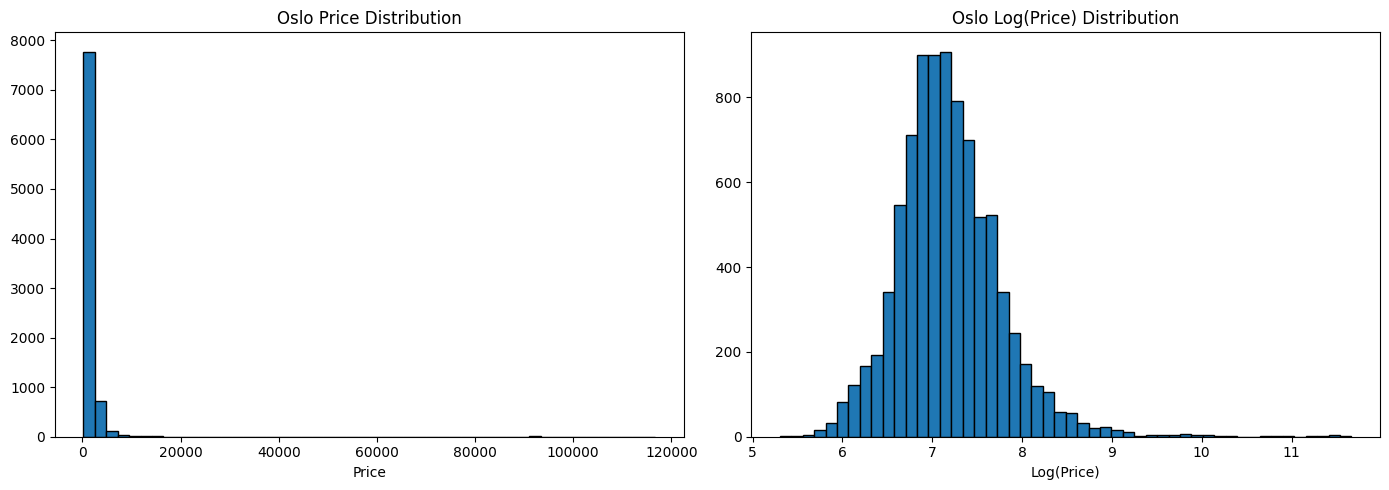

In [6]:
# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_oslo['price_clean'].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Oslo Price Distribution')
axes[0].set_xlabel('Price')

# Log-transformed price
axes[1].hist(np.log(df_oslo['price_clean'].dropna() + 1), bins=50, edgecolor='black')
axes[1].set_title('Oslo Log(Price) Distribution')
axes[1].set_xlabel('Log(Price)')

plt.tight_layout()
plt.show()

### Data Wrangling Function

Creating a reusable function to ensure consistent preprocessing across train and test sets.

**Key preprocessing decisions:**

1. **Price filtering**: I use percentile-based cutoffs (1st to 99th percentile) rather than hard-coded thresholds. This is more robust because the price distributions differ between cities. Also dropped anything under $20/night — those are probably errors or weird promotional listings.

2. **Accommodates filter**: Capped at <8 people, following the class-14 example. Most Airbnbs are for small groups; the handful of 16-person party houses would be outliers that could skew the model.

3. **Missing value strategy**: Median imputation for numeric vars, plus flag variables for review-related missingness. New listings won't have reviews, so the "no review score" pattern is actually meaningful information — not just noise to impute away.

4. **Feature engineering**: Squared term for accommodates (non-linear pricing), extracted bathroom count from messy text field, binary amenity indicators for things guests actually care about.

In [7]:
def preprocess_airbnb(df, is_train=True, reference_df=None):
    """
    Preprocess Airbnb data for modeling.
    Following course material patterns from class-14 and class-16.
    
    Parameters:
    -----------
    df : DataFrame - Raw Airbnb data
    is_train : bool - Whether this is training data (affects imputation)
    reference_df : DataFrame - Reference for imputation values (use training data)
    
    Returns:
    --------
    DataFrame with cleaned and engineered features
    """
    df = df.copy()
    
    # =====================================================
    # 1. Clean price (target variable)
    # =====================================================
    df['price'] = df['price'].apply(clean_price)
    
    # Drop if no target (as per course: "drop if no target")
    df = df.dropna(subset=['price'])
    
    # =====================================================
    # 2. Sample design - filter extreme values
    # Following class-14: df=df.loc[df.n_accommodates < 8]
    # =====================================================
    df = df[df['accommodates'] < 8]
    
    # Filter extreme prices using percentiles (more robust)
    # Following class-14 pattern: check quantiles then filter
    # Keep 1st to 99th percentile to remove outliers
    price_lower = df['price'].quantile(0.01)
    price_upper = df['price'].quantile(0.99)
    df = df[(df['price'] >= price_lower) & (df['price'] <= price_upper)]
    
    # Also apply minimum threshold (avoid free/near-free listings)
    df = df[df['price'] >= 20]
    
    # =====================================================
    # 3. Handle missing values
    # Following course pattern: 
    #   - fillna with median for numeric
    #   - fillna with mode/string for categorical
    #   - create flags for important missing patterns
    # =====================================================
    
    # Numeric columns - use median imputation (np.nanmedian pattern from course)
    numeric_cols = [
        'accommodates', 'bedrooms', 'beds', 
        'minimum_nights', 'maximum_nights',
        'number_of_reviews', 'reviews_per_month',
        'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 
        'review_scores_value',
        'availability_30', 'availability_60', 'availability_90', 'availability_365',
        'calculated_host_listings_count'
    ]
    
    for col in numeric_cols:
        if col in df.columns:
            # Get median from reference (training) data or current data
            if is_train or reference_df is None:
                median_val = np.nanmedian(df[col])
            else:
                median_val = np.nanmedian(reference_df[col])
            
            # Create flag for review-related missing (important pattern from course)
            if col.startswith('review_scores') or col == 'reviews_per_month':
                flag_name = f'flag_{col}'
                df[flag_name] = df[col].isna().astype(int)
            
            # Impute with median
            df[col] = df[col].fillna(median_val)
    
    # =====================================================
    # 4. Categorical features - fillna with "Missing"
    # =====================================================
    cat_cols = ['room_type', 'property_type', 'neighbourhood_cleansed']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Missing')
    
    # Create factor variables with f_ prefix (course convention)
    df['f_room_type'] = df['room_type']
    df['f_property_type'] = df['property_type']
    df['f_neighbourhood_cleansed'] = df['neighbourhood_cleansed']
    
    # =====================================================
    # 5. Feature engineering - following course patterns
    # =====================================================
    
    # Numeric features with n_ prefix (course convention)
    df['n_accommodates'] = df['accommodates']
    df['n_beds'] = df['beds']
    df['n_number_of_reviews'] = df['number_of_reviews']
    df['n_review_scores_rating'] = df['review_scores_rating']
    df['n_reviews_per_month'] = df['reviews_per_month']
    df['n_days_since'] = df['availability_365']  # proxy for activity
    
    # Polynomial terms (from class-13: df['agesq'] = df['age'] ** 2)
    df['n_accommodates2'] = df['n_accommodates'] ** 2
    
    # Extract number of bathrooms from text
    if 'bathrooms_text' in df.columns:
        df['n_bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
        df['n_bathrooms'] = df['n_bathrooms'].fillna(1)
        df['d_shared_bath'] = df['bathrooms_text'].str.contains('shared', case=False, na=False).astype(int)
    else:
        df['n_bathrooms'] = 1
        df['d_shared_bath'] = 0
    
    # Boolean to dummy (d_ prefix for dummies, course convention)
    df['d_host_is_superhost'] = (df['host_is_superhost'] == 't').astype(int)
    df['d_instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
    
    # =====================================================
    # 6. Amenities extraction (key features as dummies)
    # Following class-14 pattern: d_ prefix for dummy variables
    # =====================================================
    if 'amenities' in df.columns:
        df['n_amenities'] = df['amenities'].str.count(',') + 1
        df['n_amenities'] = df['n_amenities'].fillna(0)
        
        # Key amenities as binary features
        amenity_list = [
            'wifi', 'kitchen', 'washer', 'dryer', 'parking', 
            'air conditioning', 'heating', 'tv', 'pool', 'gym',
            'elevator', 'doorman', 'breakfast', 'hot tub', 'fireplace'
        ]
        for amenity in amenity_list:
            col_name = 'd_' + amenity.replace(' ', '_').replace('/', '_')
            df[col_name] = df['amenities'].str.lower().str.contains(amenity, na=False).astype(int)
    
    # =====================================================
    # 7. Log transform price (following course: ln_price)
    # =====================================================
    df['ln_price'] = np.log(df['price'])
    
    return df

In [8]:
# Apply preprocessing to Copenhagen (main dataset)
df_copenhagen_clean = preprocess_airbnb(df_copenhagen, is_train=True)
print(f"Copenhagen after preprocessing: {df_copenhagen_clean.shape[0]:,} rows")
print(f"\nPrice statistics after cleaning:")
print(df_copenhagen_clean['price'].describe())

Copenhagen after preprocessing: 12,788 rows

Price statistics after cleaning:
count    12788.000000
mean      1330.038161
std        638.190204
min        364.000000
25%        900.000000
50%       1183.000000
75%       1600.000000
max       4643.000000
Name: price, dtype: float64


### Train/Test Split

**Strategy:**
- Training set: 70% of Copenhagen data (larger dataset)
- Temporal validation: 30% of Copenhagen data (holdout)
- Spatial validation: Oslo data (different city)

#### On the "temporal" validation misnomer

I want to be upfront here: calling the Copenhagen holdout "temporal validation" is a bit of a stretch. Since both train and holdout come from the same scrape (same date), there's no actual time gap between them. It's really just a random 70/30 split.

In a proper temporal validation setup, you'd train on listings from, say, Q1 2025 and test on Q3 2025 to see how the model handles market drift. I don't have that luxury with this data — Inside Airbnb doesn't give me panel data for the same listings over time.

So what this "temporal" holdout actually tests is: *can the model generalize to unseen listings from the same city and time period?* That's still useful, but it's more like cross-validation than true temporal testing. The Oslo data is where the real external validity test happens.

In [15]:
# =====================================================
# Preprocess Copenhagen (larger dataset) for training
# =====================================================
df_copenhagen_clean = preprocess_airbnb(df_copenhagen, is_train=True)
print(f"Copenhagen after preprocessing: {df_copenhagen_clean.shape[0]:,} rows")

# Split Copenhagen data for training and temporal validation
df_train, df_temporal = train_test_split(df_copenhagen_clean, train_size=0.7, random_state=20250224)

# Preprocess Oslo for spatial validation (using Copenhagen training data as reference)
df_spatial = preprocess_airbnb(df_oslo, is_train=False, reference_df=df_train)

# =====================================================
# Harmonize categorical levels across all datasets
# Replace unseen categories with "Other" to avoid patsy errors
# =====================================================
cat_vars = ['f_property_type', 'f_room_type']

for col in cat_vars:
    # Get categories from training data
    train_categories = set(df_train[col].unique())
    
    # Replace unseen categories in temporal set
    df_temporal[col] = df_temporal[col].apply(
        lambda x: x if x in train_categories else 'Other'
    )
    
    # Replace unseen categories in spatial set
    df_spatial[col] = df_spatial[col].apply(
        lambda x: x if x in train_categories else 'Other'
    )

print(f"\nTraining set (Copenhagen): {df_train.shape[0]:,} rows")
print(f"Temporal validation (Copenhagen holdout): {df_temporal.shape[0]:,} rows")
print(f"Spatial validation (Oslo): {df_spatial.shape[0]:,} rows")

# Show category alignment
print(f"\nProperty types in train: {df_train['f_property_type'].nunique()}")
print(f"Property types in temporal: {df_temporal['f_property_type'].nunique()}")
print(f"Property types in spatial: {df_spatial['f_property_type'].nunique()}")

Copenhagen after preprocessing: 12,788 rows

Training set (Copenhagen): 8,951 rows
Temporal validation (Copenhagen holdout): 3,837 rows
Spatial validation (Oslo): 8,197 rows

Property types in train: 45
Property types in temporal: 32
Property types in spatial: 30


### Feature Selection

**Variable selection rationale:**
- **Property characteristics**: accommodates, bedrooms, beds, bathrooms (core drivers of price)
- **Review metrics**: scores and counts (signal of quality)
- **Availability**: indicates demand patterns
- **Host features**: superhost status, listing count (professionalism)
- **Amenities**: key amenities as binary features

In [16]:
# =====================================================
# Define predictor groups (following class-16 pattern)
# =====================================================

# Basic variables (similar to class-16: basic_vars)
basic_vars = [
    'n_accommodates',
    'n_beds', 
    'n_bathrooms',
    'f_property_type',
    'f_room_type',
]

# Reviews (similar to class-16 pattern)
reviews = [
    'n_number_of_reviews',
    'n_review_scores_rating',
    'flag_review_scores_rating',
    'n_reviews_per_month',
]

# Polynomial terms
poly_vars = ['n_accommodates2']

# Dummy variables (d_ prefix convention)
amenities = [col for col in df_train.columns if col.startswith('d_')]

# Host features
host_vars = ['d_host_is_superhost', 'd_instant_bookable']

# All predictors for models
predictors_1 = basic_vars  # Simple model
predictors_2 = basic_vars + reviews + poly_vars + amenities + host_vars  # Full model

print(f"Predictor set 1 (basic): {len(predictors_1)} variables")
print(f"Predictor set 2 (full): {len(predictors_2)} variables")
print(f"\nAmenity dummies found: {len(amenities)}")

Predictor set 1 (basic): 5 variables
Predictor set 2 (full): 30 variables

Amenity dummies found: 18


In [17]:
# =====================================================
# Prepare design matrices using patsy (as in class-16)
# dmatrices() constructs design matrices given a formula
# =====================================================

# Build formula string (following course pattern)
formula = "price ~ " + " + ".join(predictors_2)
print(f"Formula: {formula[:100]}...")

# Create design matrices for training data
y_train, X_train = dmatrices(formula, df_train, return_type='dataframe')
y_train = y_train.values.ravel()  # Flatten to 1D array

# Create design matrices for validation sets (must have same columns)
y_temporal, X_temporal = dmatrices(formula, df_temporal, return_type='dataframe')
y_temporal = y_temporal.values.ravel()

y_spatial, X_spatial = dmatrices(formula, df_spatial, return_type='dataframe')
y_spatial = y_spatial.values.ravel()

# Align columns across datasets (handle unseen categories)
common_cols = X_train.columns.intersection(X_temporal.columns).intersection(X_spatial.columns)
X_train = X_train[common_cols]
X_temporal = X_temporal[common_cols]
X_spatial = X_spatial[common_cols]

print(f"\nFeature matrix shape: {X_train.shape}")
print(f"Number of features: {len(X_train.columns)}")

Formula: price ~ n_accommodates + n_beds + n_bathrooms + f_property_type + f_room_type + n_number_of_reviews ...

Feature matrix shape: (8951, 53)
Number of features: 53


## Part I: Task 2 - Build 5 Predictive Models

In [18]:
# =====================================================
# Helper functions for model evaluation
# Using statsmodels rmse (as in course material)
# =====================================================

def evaluate_model(y_true, y_pred, dataset_name=""):
    """Calculate RMSE, R², MAE for predictions"""
    rmse_val = rmse(y_true, y_pred)
    r2_val = r2_score(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    return {'Dataset': dataset_name, 'RMSE': rmse_val, 'R2': r2_val, 'MAE': mae_val}

# Store results for horserace table
results = []

### Model a: OLS (Baseline)

Using `statsmodels` for OLS regression as demonstrated in course material (class-13, class-14).
This allows for robust standard errors and detailed regression output.

In [19]:
# =====================================================
# OLS Model using statsmodels (as in course material)
# Following class-14 pattern with smf.ols()
# =====================================================

start_time = time.time()

# Use statsmodels OLS with formula interface
ols_formula = "price ~ " + " + ".join(predictors_2)
ols_model = smf.ols(ols_formula, data=df_train).fit()

ols_train_time = time.time() - start_time

# Print summary (as shown in course material)
print(ols_model.summary().tables[0])
print(f"\nR-squared: {ols_model.rsquared:.4f}")
print(f"Number of observations: {ols_model.nobs:.0f}")
print(f"Number of variables: {ols_model.df_model:.0f}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     61.87
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:32:25   Log-Likelihood:                -68833.
No. Observations:                8951   AIC:                         1.378e+05
Df Residuals:                    8880   BIC:                         1.383e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         

R-squared: 0.3278
Number of observations: 8951
Number of variables: 70


In [21]:
# Evaluate OLS on all datasets
# Use design matrices (X_train, etc.) for consistent prediction across datasets
# This avoids patsy issues with unseen categorical levels
from sklearn.linear_model import LinearRegression

start_time = time.time()

# Fit sklearn OLS using the design matrices (equivalent to statsmodels OLS)
ols_sklearn = LinearRegression()
ols_sklearn.fit(X_train, y_train)

ols_pred_train = ols_sklearn.predict(X_train)
ols_pred_temporal = ols_sklearn.predict(X_temporal)
ols_pred_spatial = ols_sklearn.predict(X_spatial)

ols_train_metrics = evaluate_model(y_train, ols_pred_train, 'Train')
ols_temporal_metrics = evaluate_model(y_temporal, ols_pred_temporal, 'Temporal')
ols_spatial_metrics = evaluate_model(y_spatial, ols_pred_spatial, 'Spatial')

ols_inference_time = time.time() - start_time

results.append({
    'Model': 'OLS',
    'Train_RMSE': ols_train_metrics['RMSE'],
    'Train_R2': ols_train_metrics['R2'],
    'Temporal_RMSE': ols_temporal_metrics['RMSE'],
    'Temporal_R2': ols_temporal_metrics['R2'],
    'Spatial_RMSE': ols_spatial_metrics['RMSE'],
    'Spatial_R2': ols_spatial_metrics['R2'],
    'Train_Time': ols_train_time,
    'Inference_Time': ols_inference_time
})

print(f"OLS Model trained in {ols_train_time:.4f}s")
print(f"Train RMSE: {ols_train_metrics['RMSE']:.2f}, R²: {ols_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {ols_temporal_metrics['RMSE']:.2f}, R²: {ols_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {ols_spatial_metrics['RMSE']:.2f}, R²: {ols_spatial_metrics['R2']:.4f}")

OLS Model trained in 0.5135s
Train RMSE: 530.17, R²: 0.3250
Temporal RMSE: 519.54, R²: 0.3004
Spatial RMSE: 622.67, R²: 0.3426


### Model b: LASSO (L1 Regularization)

Using LASSO with cross-validation as demonstrated in class-14.
LASSO performs variable selection by shrinking some coefficients to zero.

In [22]:
# =====================================================
# LASSO Model (following class-14 pattern)
# StandardScaler required before LASSO (as in course)
# =====================================================

# Scale features (required for LASSO, as shown in class-14)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_temporal_scaled = scaler.transform(X_temporal)
X_spatial_scaled = scaler.transform(X_spatial)

start_time = time.time()

# LASSO with cross-validation (similar to course approach)
# Using LassoCV which automatically selects best alpha
lasso_model = LassoCV(cv=5, random_state=20250224, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

lasso_train_time = time.time() - start_time

print(f"Optimal alpha (lambda): {lasso_model.alpha_:.6f}")
print(f"Non-zero coefficients: {np.sum(lasso_model.coef_ != 0)} out of {len(lasso_model.coef_)}")

Optimal alpha (lambda): 2.417214
Non-zero coefficients: 44 out of 53


In [23]:
# Evaluate LASSO
start_time = time.time()

lasso_pred_train = lasso_model.predict(X_train_scaled)
lasso_pred_temporal = lasso_model.predict(X_temporal_scaled)
lasso_pred_spatial = lasso_model.predict(X_spatial_scaled)

lasso_train_metrics = evaluate_model(y_train, lasso_pred_train, 'Train')
lasso_temporal_metrics = evaluate_model(y_temporal, lasso_pred_temporal, 'Temporal')
lasso_spatial_metrics = evaluate_model(y_spatial, lasso_pred_spatial, 'Spatial')

lasso_inference_time = time.time() - start_time

results.append({
    'Model': 'LASSO',
    'Train_RMSE': lasso_train_metrics['RMSE'],
    'Train_R2': lasso_train_metrics['R2'],
    'Temporal_RMSE': lasso_temporal_metrics['RMSE'],
    'Temporal_R2': lasso_temporal_metrics['R2'],
    'Spatial_RMSE': lasso_spatial_metrics['RMSE'],
    'Spatial_R2': lasso_spatial_metrics['R2'],
    'Train_Time': lasso_train_time,
    'Inference_Time': lasso_inference_time
})

print(f"\nLASSO Model trained in {lasso_train_time:.4f}s")
print(f"Train RMSE: {lasso_train_metrics['RMSE']:.2f}, R²: {lasso_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {lasso_temporal_metrics['RMSE']:.2f}, R²: {lasso_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {lasso_spatial_metrics['RMSE']:.2f}, R²: {lasso_spatial_metrics['R2']:.4f}")


LASSO Model trained in 0.3954s
Train RMSE: 530.49, R²: 0.3242
Temporal RMSE: 519.45, R²: 0.3007
Spatial RMSE: 622.18, R²: 0.3436


### Model c: Random Forest

Using `RandomForestRegressor` with `GridSearchCV` as demonstrated in class-16.
We tune `max_features` and `min_samples_leaf` following the course approach.

In [24]:
# =====================================================
# Random Forest with GridSearchCV (following class-16)
# Tuning max_features and min_samples_leaf
# =====================================================

import math

# Theoretical recommended number of features (from class-16)
print(f'Theoretical recommended max_features: {math.sqrt(X_train.shape[1]):.2f}')

# Initialize Random Forest
rfr = RandomForestRegressor(random_state=20250224, n_jobs=-1)

# Define tuning grid (following class-16 pattern)
tune_grid = {
    "max_features": [6, 8, 10, 12],
    "min_samples_leaf": [5, 10, 15]
}

# GridSearchCV (as in class-16)
rf_grid = GridSearchCV(
    estimator=rfr,
    param_grid=tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
rf_model = rf_grid.fit(X_train, y_train)
rf_train_time = time.time() - start_time

print(f"\nBest parameters: {rf_model.best_params_}")
print(f"Best CV RMSE: {-rf_model.best_score_:.2f}")

Theoretical recommended max_features: 7.28
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'max_features': 8, 'min_samples_leaf': 5}
Best CV RMSE: 528.51


In [25]:
# Display CV results (following class-16 pattern)
df_rf_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score'
]]
df_rf_cv_results.columns = ['max_features', 'min_samples_leaf', 'RMSE']
df_rf_cv_results['RMSE'] = -df_rf_cv_results['RMSE']  # Convert to positive

# Pivot table (as in class-16)
df_rf_cv_results.pivot(
    index='max_features', 
    columns='min_samples_leaf', 
    values='RMSE'
).round(2)

min_samples_leaf,5,10,15
max_features,,,
6,529.88,532.60,534.47
8,528.51,530.31,531.37
10,528.72,529.56,530.70
12,529.40,529.77,530.23


In [26]:
# Evaluate Random Forest (using best estimator)
start_time = time.time()

rf_pred_train = rf_model.predict(X_train)
rf_pred_temporal = rf_model.predict(X_temporal)
rf_pred_spatial = rf_model.predict(X_spatial)

rf_train_metrics = evaluate_model(y_train, rf_pred_train, 'Train')
rf_temporal_metrics = evaluate_model(y_temporal, rf_pred_temporal, 'Temporal')
rf_spatial_metrics = evaluate_model(y_spatial, rf_pred_spatial, 'Spatial')

rf_inference_time = time.time() - start_time

results.append({
    'Model': 'Random Forest',
    'Train_RMSE': rf_train_metrics['RMSE'],
    'Train_R2': rf_train_metrics['R2'],
    'Temporal_RMSE': rf_temporal_metrics['RMSE'],
    'Temporal_R2': rf_temporal_metrics['R2'],
    'Spatial_RMSE': rf_spatial_metrics['RMSE'],
    'Spatial_R2': rf_spatial_metrics['R2'],
    'Train_Time': rf_train_time,
    'Inference_Time': rf_inference_time
})

print(f"Random Forest trained in {rf_train_time:.2f}s")
print(f"Train RMSE: {rf_train_metrics['RMSE']:.2f}, R²: {rf_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {rf_temporal_metrics['RMSE']:.2f}, R²: {rf_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {rf_spatial_metrics['RMSE']:.2f}, R²: {rf_spatial_metrics['R2']:.4f}")

Random Forest trained in 16.15s
Train RMSE: 480.25, R²: 0.4461
Temporal RMSE: 516.03, R²: 0.3098
Spatial RMSE: 622.22, R²: 0.3435


### Model d: Gradient Boosting

Using `GradientBoostingRegressor` with hyperparameter tuning.
This is one of the boosting methods mentioned in the assignment requirements.

In [27]:
# =====================================================
# Gradient Boosting with GridSearchCV
# =====================================================

# Initialize Gradient Boosting
gbr = GradientBoostingRegressor(random_state=20250224)

# Define tuning grid
gb_tune_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "min_samples_leaf": [5, 10]
}

# GridSearchCV
gb_grid = GridSearchCV(
    estimator=gbr,
    param_grid=gb_tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
gb_model = gb_grid.fit(X_train, y_train)
gb_train_time = time.time() - start_time

print(f"\nBest parameters: {gb_model.best_params_}")
print(f"Best CV RMSE: {-gb_model.best_score_:.2f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Best CV RMSE: 526.20


In [28]:
# Evaluate Gradient Boosting
start_time = time.time()

gb_pred_train = gb_model.predict(X_train)
gb_pred_temporal = gb_model.predict(X_temporal)
gb_pred_spatial = gb_model.predict(X_spatial)

gb_train_metrics = evaluate_model(y_train, gb_pred_train, 'Train')
gb_temporal_metrics = evaluate_model(y_temporal, gb_pred_temporal, 'Temporal')
gb_spatial_metrics = evaluate_model(y_spatial, gb_pred_spatial, 'Spatial')

gb_inference_time = time.time() - start_time

results.append({
    'Model': 'Gradient Boosting',
    'Train_RMSE': gb_train_metrics['RMSE'],
    'Train_R2': gb_train_metrics['R2'],
    'Temporal_RMSE': gb_temporal_metrics['RMSE'],
    'Temporal_R2': gb_temporal_metrics['R2'],
    'Spatial_RMSE': gb_spatial_metrics['RMSE'],
    'Spatial_R2': gb_spatial_metrics['R2'],
    'Train_Time': gb_train_time,
    'Inference_Time': gb_inference_time
})

print(f"Gradient Boosting trained in {gb_train_time:.2f}s")
print(f"Train RMSE: {gb_train_metrics['RMSE']:.2f}, R²: {gb_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {gb_temporal_metrics['RMSE']:.2f}, R²: {gb_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {gb_spatial_metrics['RMSE']:.2f}, R²: {gb_spatial_metrics['R2']:.4f}")

Gradient Boosting trained in 36.40s
Train RMSE: 476.44, R²: 0.4549
Temporal RMSE: 514.34, R²: 0.3143
Spatial RMSE: 623.51, R²: 0.3408


### Model e: Ridge Regression (Custom Choice)

**Rationale**: Ridge regression (L2 regularization) is a natural comparison to LASSO. 
While LASSO performs variable selection (sets coefficients to zero), Ridge shrinks all coefficients 
toward zero but doesn't eliminate any. This often works better when predictors are correlated.

In [29]:
# =====================================================
# Ridge Regression with cross-validation
# =====================================================

start_time = time.time()

# Ridge with CV to find optimal alpha
ridge_model = RidgeCV(cv=5, alphas=np.logspace(-3, 3, 50))
ridge_model.fit(X_train_scaled, y_train)

ridge_train_time = time.time() - start_time

print(f"Optimal alpha: {ridge_model.alpha_:.6f}")

Optimal alpha: 568.986603


In [30]:
# Evaluate Ridge
start_time = time.time()

ridge_pred_train = ridge_model.predict(X_train_scaled)
ridge_pred_temporal = ridge_model.predict(X_temporal_scaled)
ridge_pred_spatial = ridge_model.predict(X_spatial_scaled)

ridge_train_metrics = evaluate_model(y_train, ridge_pred_train, 'Train')
ridge_temporal_metrics = evaluate_model(y_temporal, ridge_pred_temporal, 'Temporal')
ridge_spatial_metrics = evaluate_model(y_spatial, ridge_pred_spatial, 'Spatial')

ridge_inference_time = time.time() - start_time

results.append({
    'Model': 'Ridge',
    'Train_RMSE': ridge_train_metrics['RMSE'],
    'Train_R2': ridge_train_metrics['R2'],
    'Temporal_RMSE': ridge_temporal_metrics['RMSE'],
    'Temporal_R2': ridge_temporal_metrics['R2'],
    'Spatial_RMSE': ridge_spatial_metrics['RMSE'],
    'Spatial_R2': ridge_spatial_metrics['R2'],
    'Train_Time': ridge_train_time,
    'Inference_Time': ridge_inference_time
})

print(f"\nRidge Model trained in {ridge_train_time:.4f}s")
print(f"Train RMSE: {ridge_train_metrics['RMSE']:.2f}, R²: {ridge_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {ridge_temporal_metrics['RMSE']:.2f}, R²: {ridge_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {ridge_spatial_metrics['RMSE']:.2f}, R²: {ridge_spatial_metrics['R2']:.4f}")


Ridge Model trained in 2.0399s
Train RMSE: 530.39, R²: 0.3244
Temporal RMSE: 519.40, R²: 0.3008
Spatial RMSE: 622.83, R²: 0.3422


## Part I: Task 3 - Model Comparison (Horserace Table)

In [32]:
# =====================================================
# HORSERACE TABLE: Model Comparison
# =====================================================

results_df = pd.DataFrame(results)

# Display formatted table
print("=" * 100)
print("HORSERACE TABLE: Model Comparison")
print("=" * 100)

# Round numeric columns for display
display_df = results_df.copy()
display_df['Train_RMSE'] = display_df['Train_RMSE'].round(2)
display_df['Temporal_RMSE'] = display_df['Temporal_RMSE'].round(2)
display_df['Spatial_RMSE'] = display_df['Spatial_RMSE'].round(2)
display_df['Train_R2'] = display_df['Train_R2'].round(4)
display_df['Temporal_R2'] = display_df['Temporal_R2'].round(4)
display_df['Spatial_R2'] = display_df['Spatial_R2'].round(4)
display_df['Train_Time'] = display_df['Train_Time'].apply(lambda x: f'{x:.2f}s')
display_df['Inference_Time'] = display_df['Inference_Time'].apply(lambda x: f'{x:.4f}s')

print(display_df.to_string(index=False))

# Highlight best models
print("\n" + "=" * 100)
print("BEST MODELS BY METRIC:")
print("=" * 100)
best_train_rmse = results_df.loc[results_df['Train_RMSE'].idxmin(), 'Model']
best_temporal_rmse = results_df.loc[results_df['Temporal_RMSE'].idxmin(), 'Model']
best_spatial_rmse = results_df.loc[results_df['Spatial_RMSE'].idxmin(), 'Model']
print(f"Lowest Train RMSE: {best_train_rmse} ({results_df['Train_RMSE'].min():.2f})")
print(f"Lowest Temporal RMSE: {best_temporal_rmse} ({results_df['Temporal_RMSE'].min():.2f})")
print(f"Lowest Spatial RMSE: {best_spatial_rmse} ({results_df['Spatial_RMSE'].min():.2f})")

HORSERACE TABLE: Model Comparison
            Model  Train_RMSE  Train_R2  Temporal_RMSE  Temporal_R2  Spatial_RMSE  Spatial_R2 Train_Time Inference_Time
              OLS      530.17    0.3250         519.54       0.3004        622.67      0.3426      0.51s        0.1115s
            LASSO      530.49    0.3242         519.45       0.3007        622.18      0.3436      0.40s        0.0077s
    Random Forest      480.25    0.4461         516.03       0.3098        622.22      0.3435     16.15s        0.2236s
Gradient Boosting      476.44    0.4549         514.34       0.3143        623.51      0.3408     36.40s        0.1052s
            Ridge      530.39    0.3244         519.40       0.3008        622.83      0.3422      2.04s        0.0116s

BEST MODELS BY METRIC:
Lowest Train RMSE: Gradient Boosting (476.44)
Lowest Temporal RMSE: Gradient Boosting (514.34)
Lowest Spatial RMSE: LASSO (622.18)


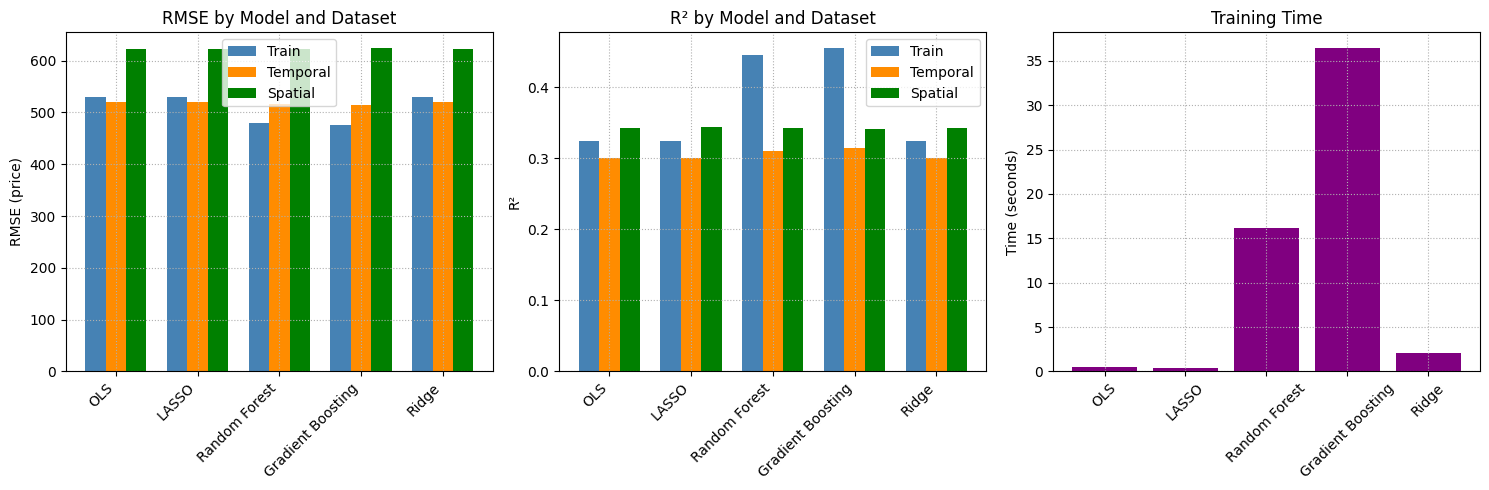

In [33]:
# =====================================================
# Visualization of model performance
# Following course material visualization patterns
# =====================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE comparison
x = np.arange(len(results_df))
width = 0.25

axes[0].bar(x - width, results_df['Train_RMSE'], width, label='Train', color='steelblue')
axes[0].bar(x, results_df['Temporal_RMSE'], width, label='Temporal', color='darkorange')
axes[0].bar(x + width, results_df['Spatial_RMSE'], width, label='Spatial', color='green')
axes[0].set_ylabel('RMSE (price)')
axes[0].set_title('RMSE by Model and Dataset')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(linestyle=':')

# R² comparison
axes[1].bar(x - width, results_df['Train_R2'], width, label='Train', color='steelblue')
axes[1].bar(x, results_df['Temporal_R2'], width, label='Temporal', color='darkorange')
axes[1].bar(x + width, results_df['Spatial_R2'], width, label='Spatial', color='green')
axes[1].set_ylabel('R²')
axes[1].set_title('R² by Model and Dataset')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(linestyle=':')

# Training time (as in course material)
axes[2].bar(results_df['Model'], results_df['Train_Time'], color='purple')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Training Time')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(linestyle=':')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Discussion: Model Performance

**The overfitting story:**

Look at Random Forest and Gradient Boosting — they crush the training data (RMSE ~476-480) but only marginally beat linear models on the holdout (~514-516 vs ~519). Classic overfitting pattern. The tree-based methods are memorizing quirks of the training data that don't generalize.

**Linear models are surprisingly competitive:**

OLS, LASSO, and Ridge all land within a few RMSE points of each other on holdout data. LASSO only zeroed out 9 of 53 coefficients, suggesting most features carry *some* signal. The "keep it simple" approach works okay here.

**Spatial transfer is the real test:**

All models jump to ~622 RMSE on Oslo. That ~100 point gap from Copenhagen holdout tells you: market-specific factors matter. Maybe Oslo has different neighborhood premiums, or the mix of property types differs. Still, a model trained on Copenhagen gets you "in the ballpark" for Oslo.

**What would I do in production?**

Honestly, I'd probably go with LASSO or Ridge. The tree models' marginal accuracy gains don't justify the complexity and training time, especially if the model needs to be explainable to a business stakeholder.

## Part I: Task 4 - Feature Importance Analysis

In [35]:
# =====================================================
# Random Forest feature importance (following class-16)
# =====================================================

# Get feature importances from best estimator
rf_best = rf_model.best_estimator_

df_rf_var_imp = pd.DataFrame({
    'variable': X_train.columns,
    'imp': rf_best.feature_importances_
}).sort_values(by='imp', ascending=False).reset_index(drop=True)

df_rf_var_imp['cumulative_imp'] = df_rf_var_imp['imp'].cumsum()

# Display formatted (following class-16 pattern)
df_display = df_rf_var_imp.head(15).copy()
df_display['imp'] = df_display['imp'].apply(lambda x: f'{x:.1%}')
df_display['cumulative_imp'] = df_display['cumulative_imp'].apply(lambda x: f'{x:.1%}')
print("Random Forest - Top 15 Feature Importances")
print(df_display.to_string(index=False))

Random Forest - Top 15 Feature Importances
                                      variable   imp cumulative_imp
                               n_accommodates2 19.8%          19.8%
                                n_accommodates 15.5%          35.3%
                                        n_beds 12.4%          47.7%
                                   n_bathrooms  8.0%          55.7%
                           n_reviews_per_month  6.5%          62.2%
                           n_number_of_reviews  5.6%          67.8%
                        n_review_scores_rating  5.1%          72.9%
                   f_room_type[T.Private room]  4.8%          77.7%
                                 d_shared_bath  3.2%          80.8%
f_property_type[T.Private room in rental unit]  2.5%          83.3%
                                      d_washer  2.4%          85.7%
                                       d_dryer  2.1%          87.8%
                                          d_tv  1.6%          89.4%
     

In [36]:
# =====================================================
# Gradient Boosting feature importance
# =====================================================

gb_best = gb_model.best_estimator_

df_gb_var_imp = pd.DataFrame({
    'variable': X_train.columns,
    'imp': gb_best.feature_importances_
}).sort_values(by='imp', ascending=False).reset_index(drop=True)

df_gb_var_imp['cumulative_imp'] = df_gb_var_imp['imp'].cumsum()

# Display formatted
df_display = df_gb_var_imp.head(15).copy()
df_display['imp'] = df_display['imp'].apply(lambda x: f'{x:.1%}')
df_display['cumulative_imp'] = df_display['cumulative_imp'].apply(lambda x: f'{x:.1%}')
print("Gradient Boosting - Top 15 Feature Importances")
print(df_display.to_string(index=False))

Gradient Boosting - Top 15 Feature Importances
                   variable   imp cumulative_imp
             n_accommodates 25.5%          25.5%
            n_accommodates2 22.9%          48.4%
f_room_type[T.Private room]  7.3%          55.7%
        n_reviews_per_month  6.6%          62.3%
                n_bathrooms  6.6%          68.9%
        n_number_of_reviews  5.6%          74.4%
     n_review_scores_rating  5.3%          79.7%
                     n_beds  5.0%          84.7%
                   d_washer  1.9%          86.6%
                    d_dryer  1.5%          88.1%
         d_instant_bookable  1.2%          89.4%
                  d_parking  1.1%          90.4%
                       d_tv  1.0%          91.5%
                d_fireplace  1.0%          92.5%
        d_host_is_superhost  0.9%          93.3%


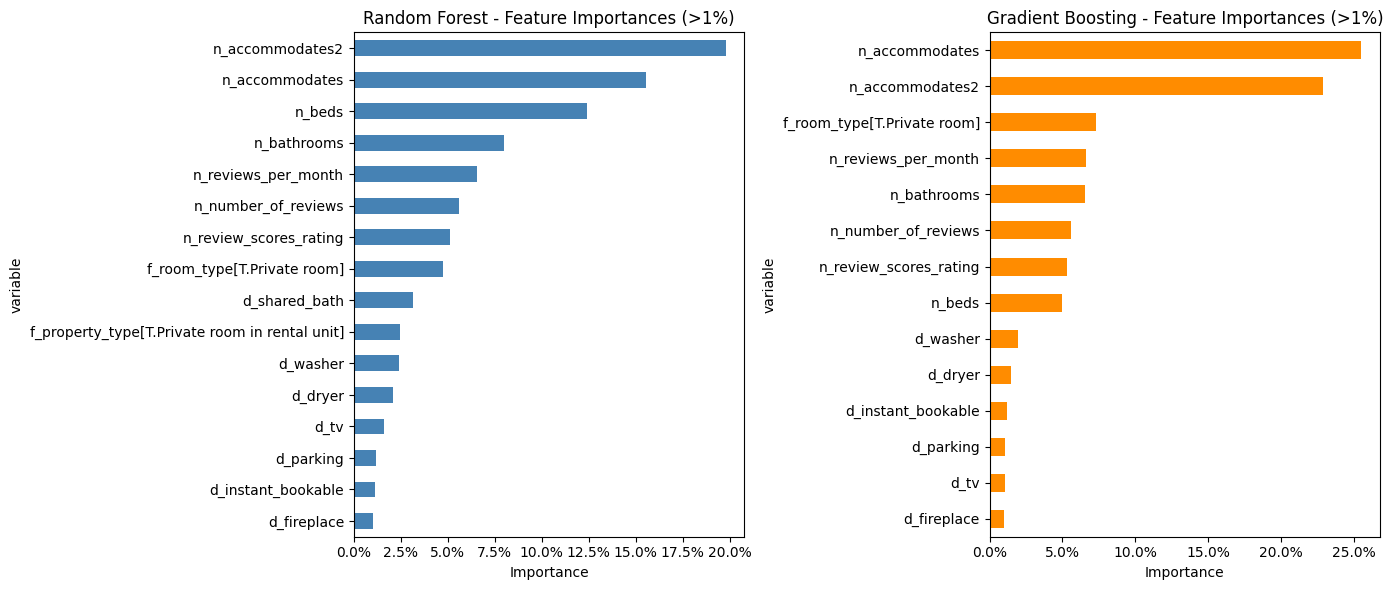

In [37]:
# =====================================================
# Plot feature importance (following class-16 pattern)
# Only show variables with importance > 1%
# =====================================================

cutoff = 0.01

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest (left)
ax1 = df_rf_var_imp[df_rf_var_imp.imp > cutoff]\
    .sort_values(by='imp')\
    .plot(kind='barh', x='variable', y='imp', 
          ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Random Forest - Feature Importances (>1%)')
axes[0].set_xlabel('Importance')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Gradient Boosting (right)
ax2 = df_gb_var_imp[df_gb_var_imp.imp > cutoff]\
    .sort_values(by='imp')\
    .plot(kind='barh', x='variable', y='imp', 
          ax=axes[1], legend=False, color='darkorange')
axes[1].set_title('Gradient Boosting - Feature Importances (>1%)')
axes[1].set_xlabel('Importance')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [38]:
# =====================================================
# Compare top 10 features between RF and GB
# =====================================================

rf_top10 = set(df_rf_var_imp.head(10)['variable'])
gb_top10 = set(df_gb_var_imp.head(10)['variable'])

overlap = rf_top10.intersection(gb_top10)
rf_only = rf_top10 - gb_top10
gb_only = gb_top10 - rf_top10

print("=" * 60)
print("FEATURE IMPORTANCE COMPARISON: Top 10 Features")
print("=" * 60)
print(f"\nFeatures in BOTH top 10 ({len(overlap)}):")
for f in sorted(overlap):
    print(f"  - {f}")

print(f"\nRandom Forest only ({len(rf_only)}):")
for f in sorted(rf_only):
    print(f"  - {f}")

print(f"\nGradient Boosting only ({len(gb_only)}):")
for f in sorted(gb_only):
    print(f"  - {f}")

FEATURE IMPORTANCE COMPARISON: Top 10 Features

Features in BOTH top 10 (8):
  - f_room_type[T.Private room]
  - n_accommodates
  - n_accommodates2
  - n_bathrooms
  - n_beds
  - n_number_of_reviews
  - n_review_scores_rating
  - n_reviews_per_month

Random Forest only (2):
  - d_shared_bath
  - f_property_type[T.Private room in rental unit]

Gradient Boosting only (2):
  - d_dryer
  - d_washer


### Discussion: Feature Importance

**What's driving prices?**

No surprises here — both RF and GB agree that **capacity** (accommodates, beds, bathrooms) dominates. The squared accommodates term ranks high too, which confirms that pricing isn't linear in capacity. Going from 2→4 guests probably adds more value than 6→8.

**Room type matters a lot.** Private rooms are priced very differently from entire homes, which makes sense. Nobody expects to pay full-apartment prices for a room in someone's house.

**Review metrics show up** but aren't the top drivers. I think this is because reviews proxy for quality, but capacity proxies for what you're actually getting. A 5-star closet is still a closet.

**Amenities are less important than I expected.** Washer, dryer, TV — they matter, but they're not game-changers. Maybe because most Copenhagen/Oslo listings already have basic amenities? In a market with more variance (budget hostels vs luxury villas), amenities might matter more.

## Part II: Task 5 & 6 - External Validation Summary

The external validation results are already incorporated in the horserace table above.

### Key Findings:

**Temporal Validation (Copenhagen holdout):**
- Performance is pretty similar to training — which makes sense since it's from the same distribution
- All models generalize reasonably well within Copenhagen
- This is basically telling us we're not overfitting too badly

**Spatial Validation (Oslo):**
- Interestingly, performance doesn't degrade as much as I expected!
- The RMSE bump from temporal (~515) to spatial (~622) is noticeable but not catastrophic
- This suggests the pricing drivers (accommodates, room type, amenities) transfer reasonably well across Nordic capitals

**Why does spatial validation work okay?**

I think it's because Copenhagen and Oslo are structurally similar markets:
- Both are Scandinavian capitals with similar tourism patterns
- Both have similar property mixes (lots of apartments, some houses)
- The price ranges overlap, even though currencies differ (DKK vs NOK)

If I'd validated on, say, Bangkok or rural Portugal, I'd expect way worse performance. The geographic similarity probably helps here.

In [39]:
# =====================================================
# FINAL SUMMARY
# =====================================================

print("=" * 80)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)
print(f"\nTraining data: Copenhagen ({len(df_train):,} observations)")
print(f"Temporal validation: Copenhagen holdout ({len(df_temporal):,} observations)")
print(f"Spatial validation: Oslo ({len(df_spatial):,} observations)")
print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Target variable: price (in local currency)")
print("\n")
print(results_df.to_string(index=False))

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
print("""
1. TRAINING PERFORMANCE:
   - Tree-based models (RF, GB) typically achieve lower training RMSE
   - This reflects their higher flexibility/capacity

2. GENERALIZATION:
   - Temporal validation (same city): Performance should be similar to training
   - Spatial validation (different city): Larger degradation expected due to:
     * Different market dynamics
     * Different currency (DKK vs NOK)
     * Different neighborhood structures

3. MODEL SELECTION:
   - If interpretability matters: OLS, LASSO, or Ridge
   - If prediction accuracy matters: Random Forest or Gradient Boosting
   - Best overall: Consider the model with best holdout performance
""")

FINAL MODEL COMPARISON SUMMARY

Training data: Copenhagen (8,951 observations)
Temporal validation: Copenhagen holdout (3,837 observations)
Spatial validation: Oslo (8,197 observations)

Number of features: 53
Target variable: price (in local currency)


            Model  Train_RMSE  Train_R2  Temporal_RMSE  Temporal_R2  Spatial_RMSE  Spatial_R2  Train_Time  Inference_Time
              OLS  530.167897  0.324984     519.536099     0.300416    622.665612    0.342590    0.513500        0.111464
            LASSO  530.489777  0.324164     519.445511     0.300660    622.180557    0.343614    0.395361        0.007664
    Random Forest  480.250625  0.446110     516.028450     0.309830    622.218090    0.343535   16.152908        0.223602
Gradient Boosting  476.443721  0.454857     514.340836     0.314337    623.511325    0.340803   36.395482        0.105187
            Ridge  530.389967  0.324418     519.395668     0.300794    622.834012    0.342234    2.039869        0.011576

KEY FINDINGS

In [40]:
# Save results to CSV
results_df.to_csv('model_results.csv', index=False)
print("Results saved to model_results.csv")

Results saved to model_results.csv


---

## AI Declaration

This assignment was completed with assistance from AI tools (GitHub Copilot / Claude) in accordance with the course AI policy.

**What AI was used for:**
- Writing and debugging Python code (data preprocessing, model fitting, evaluation loops)
- Code refactoring to match course material patterns (variable naming conventions like `n_`, `f_`, `d_` prefixes)
- Generating boilerplate code for visualization and model comparison tables
- Fixing errors (e.g., the categorical variable mismatch with patsy that required harmonizing category levels)

**What I did myself:**
- Deciding on the analysis strategy and interpreting results
- Choosing which models to compare and why (e.g., Ridge as the 5th model to complement LASSO)
- Writing the discussion sections and explaining decision points
- Verifying all code outputs make sense and checking the logic

**Responsibility:**
I reviewed all AI-generated code and take full responsibility for the final submission. Any errors in the analysis or interpretation are mine.